In [1]:
from dataset import DataLoader, DataVisualizer, DatasetBuilder
#from models import *
import tensorflow as tf
from utils.input import *

2023-06-03 10:43:25.705291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 10:43:25.752928: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-03 10:43:25.752973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-03 10:43:25.752999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-03 10:43:25.761331: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 10:43:25.762269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data = DataLoader(path='DATA/speech_commands_v0.02')

In [3]:
commands = data.get_commands()
commands

array(['yes', 'off', 'five', 'eight', 'nine', 'six', 'up', 'no', 'two',
       'tree', 'follow', 'three', 'backward', 'down', 'on', 'right',
       'one', 'visual', 'happy', 'sheila', 'dog', 'zero', 'wow', 'bed',
       'house', 'cat', 'stop', 'marvin', 'learn', 'four', 'left',
       'forward', 'seven', 'go', 'bird'], dtype='<U19')

In [4]:
filenames = data.get_filenames()

In [5]:
train_files, val_files, test_files = data.split_data(filenames)

In [6]:
ds = DatasetBuilder(
    commands=commands,
    train_filenames=train_files,
    val_filenames=val_files,
    test_filenames=test_files,
    batch_size=64,
    buffer_size=1000,
    method='STFT',
)


In [7]:
train, test, val = ds.preprocess_dataset_spectrogram()

Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 88)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 62)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (40, 98)
Log Mel-spectrogram shape: (

KeyboardInterrupt: 

In [34]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [35]:
train_waveforms = data.get_waveform_ds(train_files)

In [36]:
#x = data.get_waveform_data(train_files)
#x

In [37]:
for waveform, label in train_waveforms.take(1):
  print("Waveform shape: ", waveform.numpy().shape)
  print("Label: ", label.numpy())

Waveform shape:  (16000,)
Label:  b'house'


In [38]:
spectrograms = data.get_spectrogram_STFT_ds(
    train_waveforms,
    commands
)

for spectrogram, label in spectrograms.take(1):
    print('Label:', label.numpy())
    print('Spectrogram shape:', spectrogram.shape)

Label: 24
Spectrogram shape: (257, 98, 1)


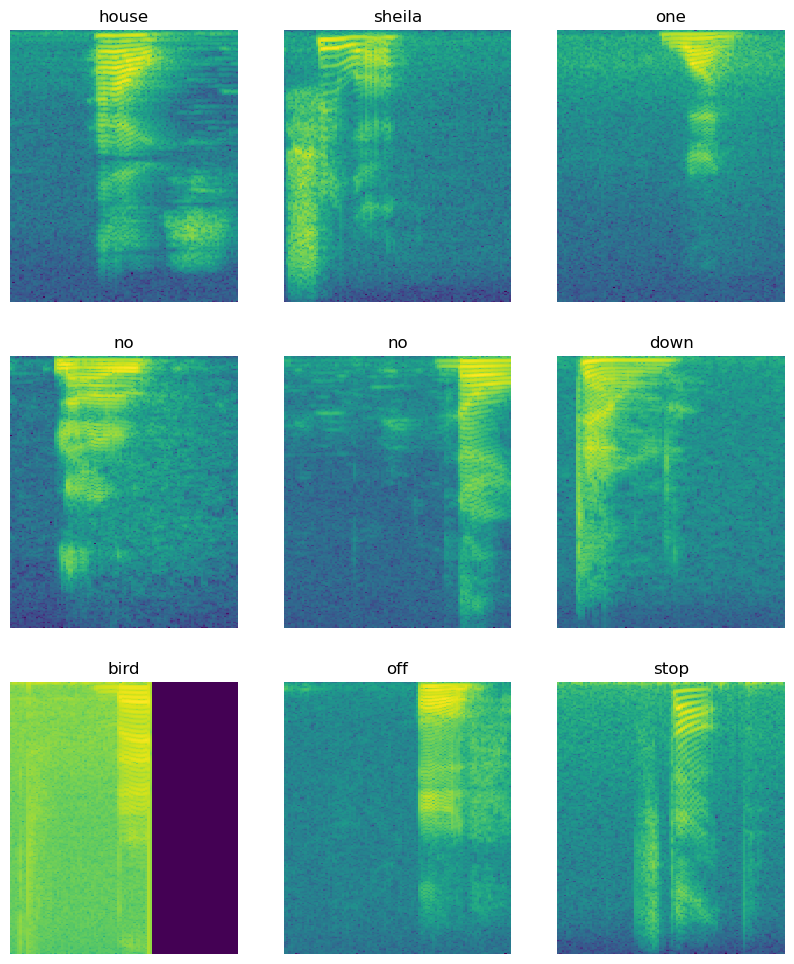

In [39]:
visual = DataVisualizer(train_waveforms, spectrograms, commands)

visual.plot_spectrogram_example()

In [40]:
for spectrogram, _ in spectrograms.take(1):
    print(spectrogram.numpy().shape)
    print(visual.commands[_.numpy()])

(257, 98, 1)
house


In [41]:
train_spectrograms = data.get_spectrogram_logmel_ds(
    train_waveforms,
    commands
)
train_spectrograms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(40, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [42]:
mfcc_spectrograms = data.get_spectrogram_mfcc_ds(
    train_waveforms,
    commands
)
mfcc_spectrograms

<_ParallelMapDataset element_spec=(TensorSpec(shape=(13, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [43]:
for i, (spectrogram, label) in enumerate(train_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', label.numpy())

Spectrogram shape:  (40, 98)
Label:  24


In [44]:
from dataset import DataVisualizer
visual = DataVisualizer(train_waveforms, train_spectrograms, commands)

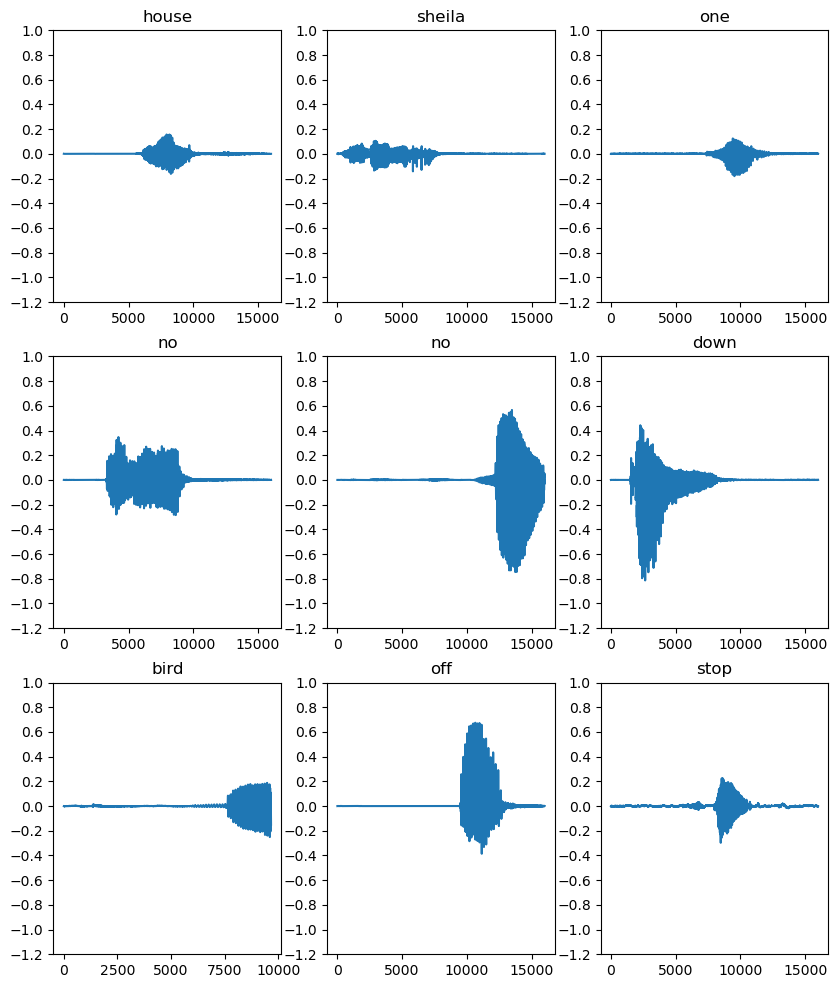

In [45]:
visual.plot_waveform_example()

In [46]:
visual.listen_waveform(save=True)

Label: house
Waveform shape: (16000,)
Spectrogram shape: (257, 98, 1)
Audio playback


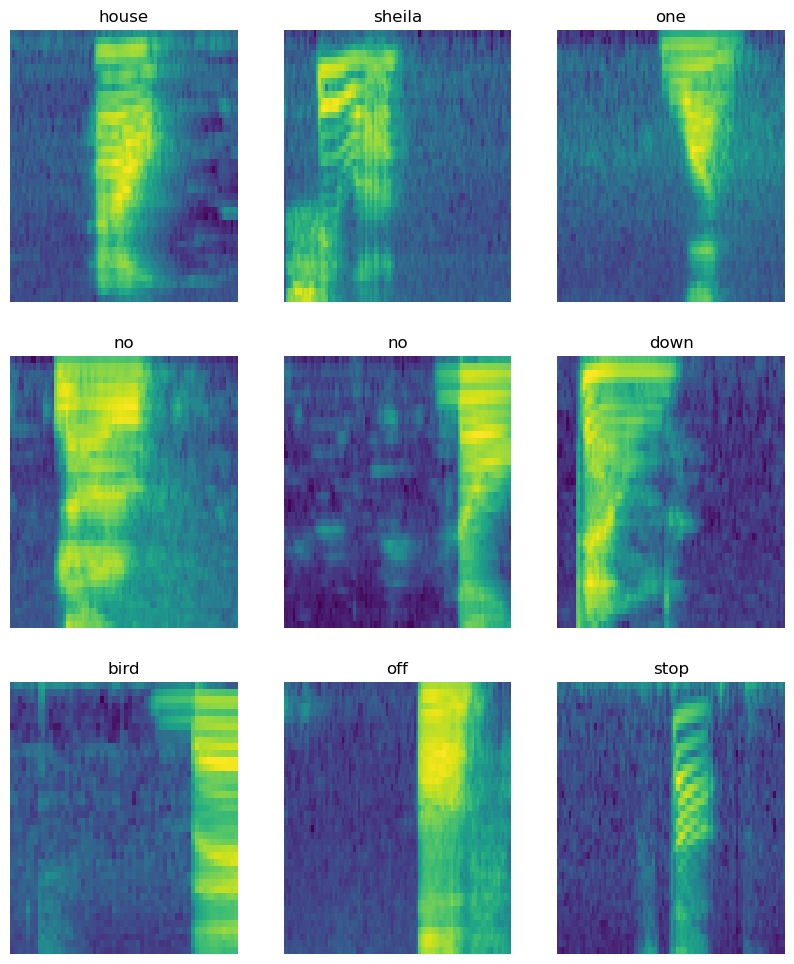

In [47]:
visual.plot_spectrogram_example()

In [48]:
from utils.plot import plot_features

Spectrogram shape:  (40, 98)
Label:  house


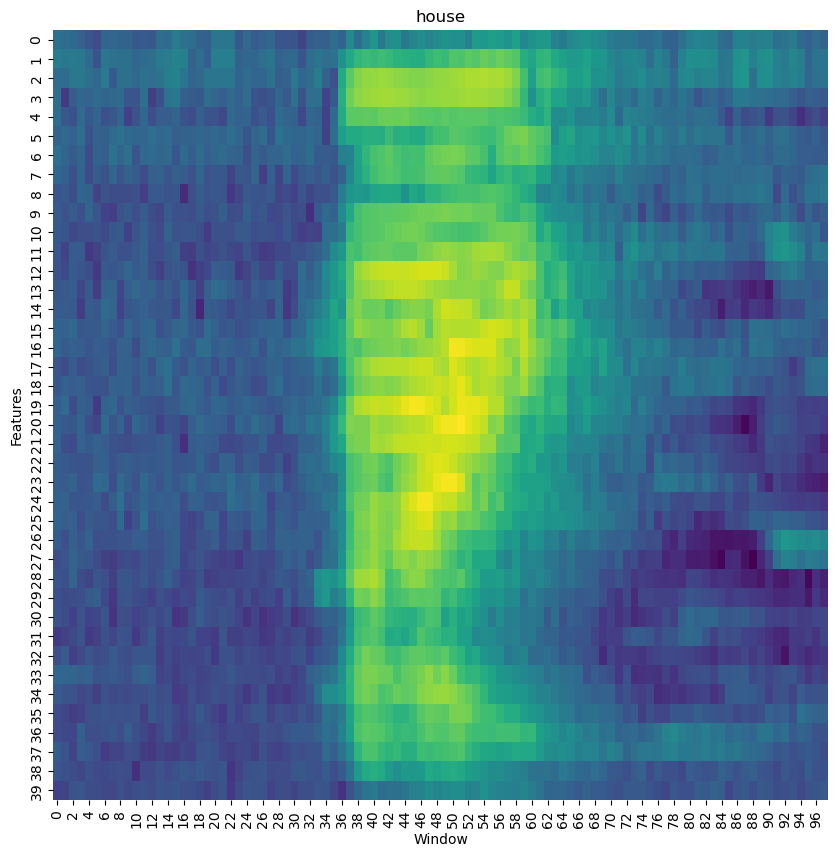

In [49]:
import matplotlib.pyplot as plt

for i, (spectrogram, label) in enumerate(train_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', visual.commands[label.numpy()])
  fig, axes = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), axes)
  axes.set_title(visual.commands[label.numpy()])

Spectrogram shape:  (13, 98)
Label:  house


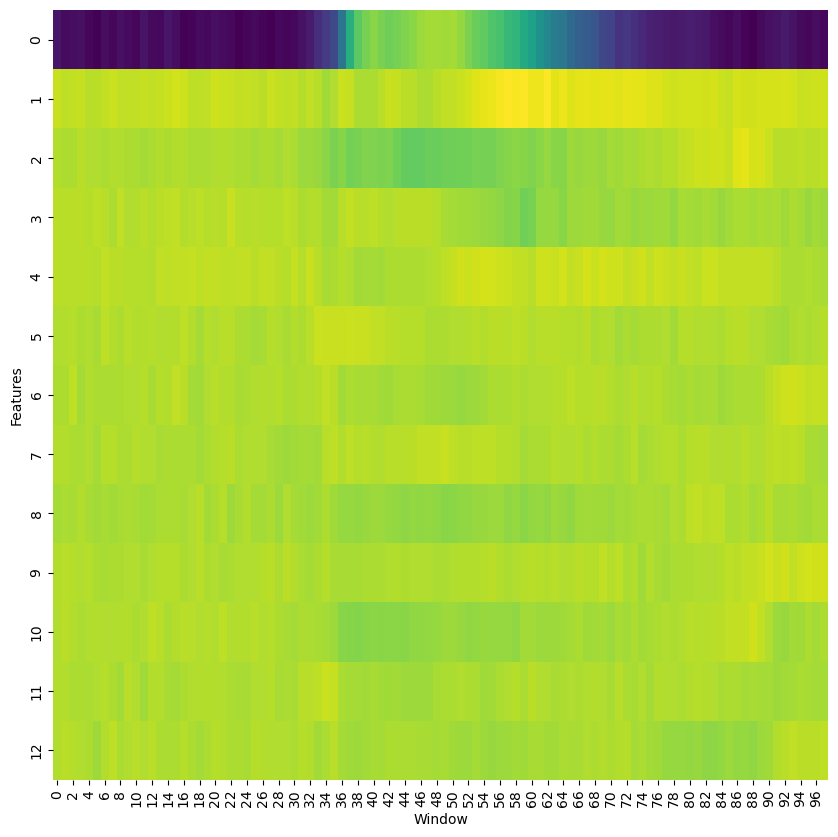

In [50]:
import matplotlib.pyplot as plt
import numpy as np

for i, (spectrogram, label) in enumerate(mfcc_spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', visual.commands[label.numpy()])
  fig, axes = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), axes)
  plt.show()

Spectrogram shape:  (257, 98, 1)
Label:  24


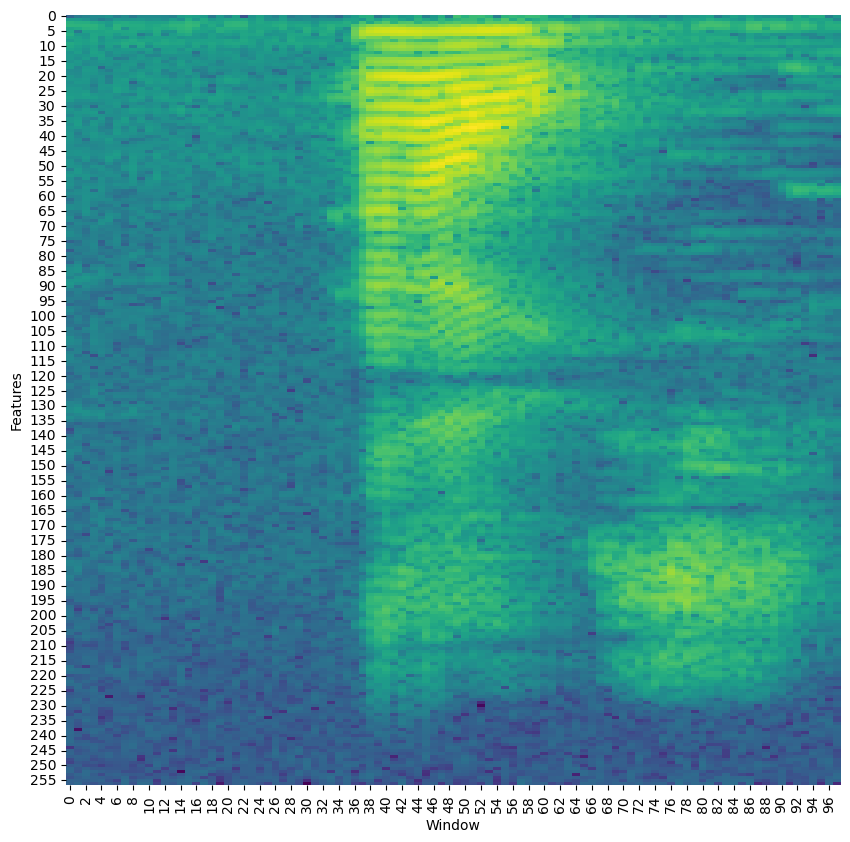

In [51]:
for i, (spectrogram, label) in enumerate(spectrograms.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy().shape)
  print('Label: ', label.numpy())
  fig, ax = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), ax)

In [56]:
for i, (spectrogram_batch, label_batch) in enumerate(train.take(1)):
    for spectrogram in spectrogram_batch:
        spectrogram_shape = tf.shape(spectrogram)
        print("Spectrogram shape:", spectrogram_shape)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [40,98] and element 20 had shape [40,88]. [Op:IteratorGetNext] name: 

In [26]:
from models import CNNTradFPool3

model = CNNTradFPool3(
    train_ds = train,
    test_ds = test,
    val_ds = val,
    commands = commands,
)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [40,98] and element 21 had shape [40,83]. [Op:IteratorGetNext] name: 

In [ ]:
model.create_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 98)]          0         
                                                                 
 resizing_1 (Resizing)       (32, 32, 98)              0         
                                                                 
 normalization (Normalizati  (32, 32, 98)              3         
 on)                                                             
                                                                 
 tf.expand_dims_1 (TFOpLamb  (32, 32, 98, 1)           0         
 da)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 32, 98, 64)          10304     
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 32, 32, 64)          0   

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import tensorboard

In [ ]:
name_model = 'CNNTradFPool3'

In [37]:
model_tensorboad_callback = TensorBoard(log_dir="logs/{}".format(name_model))
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
history = model.fit(
    epochs=10,
    callbacks=[model_checkpoint_callback],
    verbose=1,
    return_history=True,)

Epoch 1/10


ValueError: in user code:

    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1364, in train_function  *
        return step_function(self, iterator)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1348, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1329, in run_step  **
        outputs = model.train_step(data)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/training.py", line 1106, in train_step
        y_pred = self(x, training=True)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'resizing_1' (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received by layer 'resizing_1' (type Resizing):
      • inputs=tf.Tensor(shape=(40, None), dtype=float32)


In [46]:
model.input_shape

TensorShape([40, 98])

Spectrogram shape:  (40, 98)
Label:  ()


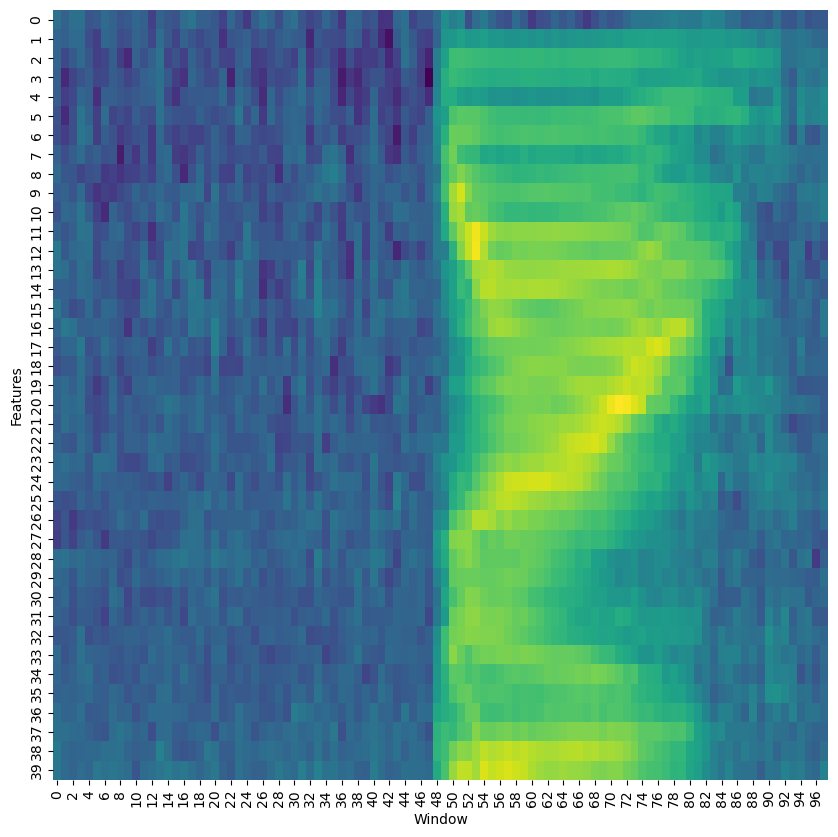

In [45]:
for i, (spectrogram, label) in enumerate(model.train_ds.take(1)):
  print('Spectrogram shape: ', spectrogram.shape)
  print('Label: ', label.shape)
  fig, ax = plt.subplots(1, figsize=(10, 10))
  plot_features(spectrogram.numpy(), ax)

In [35]:
model.input_shape

TensorShape([40, 98])

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,\
                                    Flatten, Dense, Input,\
                                    Resizing

input = Input(model.input_shape)

In [39]:
a = Resizing(32,32)(input)
a = model.norm_layer(a)

In [40]:
a = tf.expand_dims(a, -1)
a

<KerasTensor: shape=(32, 32, 98, 1) dtype=float32 (created by layer 'tf.expand_dims_2')>

In [41]:
Conv2D(
    filters=64,
    kernel_size=(20,8),
    activation='relu',
    padding='same',
)(a)

<KerasTensor: shape=(32, 32, 98, 64) dtype=float32 (created by layer 'conv2d_4')>

In [44]:
a

<KerasTensor: shape=(32, 3136) dtype=float32 (created by layer 'flatten_1')>

In [ ]:
#norm_layer = tf.keras.layers.Normalization(axis=-1)
#
#dummy_input = tf.keras.Input(shape=model.input_shape[1:], name='Input')
#norm_layer.adapt(dummy_input)
#norm_layer

batch_size = 64

norm_layer = tf.keras.layers.Normalization(axis=-1)
# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
dummy_input = tf.zeros(shape=(batch_size,) + model.input_shape[1:])
norm=norm_layer.adapt(data=dummy_input)

norm(tf.zeros(shape=(batch_size,) + model.input_shape[1:]))

TypeError: 'NoneType' object is not callable

In [ ]:
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train.map(map_func=lambda spec, label: spec))

2023-06-02 22:39:00.269047: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:39:00.269261: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


ValueError: in user code:

    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/base_preprocessing_layer.py", line 122, in adapt_step  *
        self._adapt_maybe_build(data)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/engine/base_preprocessing_layer.py", line 295, in _adapt_maybe_build  **
        self.build(data_shape)
    File "/home/aidin/anaconda3/envs/HDA/lib/python3.8/site-packages/keras/src/layers/preprocessing/normalization.py", line 188, in build
        raise ValueError(

    ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [40, None], with unknown axis at index: 1


In [58]:
for spec in train.map(
    map_func = lambda spec, label: spec
).take(1): print(tf.keras.layers.Normalization())

2023-06-02 22:27:41.555767: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:27:41.556127: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [36]:
tf.__version__

'2.14.0-dev20230523'

In [37]:
adapt_data = np.array([1., 2., 3., 4., 5.], dtype='float32')
input_data = np.array([1., 2., 3.], dtype='float32')
layer = tf.keras.layers.Normalization(axis=None)
layer.adapt(adapt_data)
layer(input_data)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4142135 , -0.70710677,  0.        ], dtype=float32)>

In [28]:
a = train.map(
    map_func = lambda spec, label: spec
)

layer = tf.keras.layers.Normalization(axis=None)
layer.adapt(a)

2023-06-02 23:22:44.347962: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 23:22:44.348166: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


In [29]:
layer()

In [40]:
layer

In [ ]:
import tensorflow as tf

tf.keras.layers.Normalization().adapt(data)

2023-06-02 22:21:55.288832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 22:21:55.333223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-02 22:21:55.333253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-02 22:21:55.333269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-02 22:21:55.341841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 22:21:55.342528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

NameError: name 'data' is not defined

In [ ]:
for i, spectrogram in enumerate(data.take(1)):
  print('Spectrogram shape: ', spectrogram.numpy())

2023-06-02 22:19:59.303902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:19:59.304737: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [84663]
	 [[{{node Placeholder/_0}}]]


Spectrogram shape:  [[-8.084161  -7.4094577 -8.041817  ... -6.5123463 -6.3396134 -6.848423 ]
 [-6.929613  -7.538925  -7.3320603 ... -5.643735  -6.306602  -6.2586904]
 [-6.761951  -7.407536  -6.6224604 ... -5.2255635 -6.1703243 -6.5690527]
 ...
 [-6.36265   -6.482527  -6.8747015 ... -6.046159  -5.95908   -6.1442876]
 [-6.192444  -6.344539  -5.924209  ... -5.9950767 -5.82529   -5.581264 ]
 [-5.9521194 -6.580887  -6.0298157 ... -5.451576  -5.346531  -5.882458 ]]


In [ ]:
norm_layer = tf.keras.layers.Normalization().adapt(spectrogram)